# COGS 118A - Project Checkpoint

# Names

Hopefully your team is at least this good. Obviously you should replace these with your names.

- Tyden Rucker
- Areen Lu
- Anya Bodhisartha
- Nikhil Deepak
- Jason Xu

# Abstract 

Pests are one of the main issues in the agricultural industry we have today. If left unchecked, they can damage plants, food supplies, and property. According to the research, using machine learning improves the accuracy of insect detection than the traditional insect identification method.
In this project, we are aiming to classify and detect insect pests that have greatly affected agricultural products. Additionally, we want to measure the accuracy of different machine learning methods. The data are images which are already classified and labeled. Using this data, we will be processing the data then constructing a model to create a multi-class classifier and use mean squared error or cross validation to compare different models. Utilizing different evaluation metrics such as precision and recall and cross validation, we will determine the best hyperparameters and model. Our project will focus on model selection as well as algorithm selection to determine the best model that accurately predicts the class of the insect given an image. 

# Background

Agriculture is a substantial aspect of the world economy making up 5.4% of the United States GDP in 2021. This percentage amounts to $1.264 trillion.<a name="USDA"></a>[<sup>[1]</sup>](#USDA)The performance of the agricultural sector has wide ranging ramifications and implications in all parts of everyday life. 

Insects are a critical component of the agricultural ecosystem. From major pollinators such as bees and mosquitoes to pests such as aphids, some insects provide vital services to farmers while others could possibly be detrimental to the survival of a crop and subsequently the livelihood of surrounding settlements. Large quantities of pests such as grasshoppers, locusts, and caterpillars can result in widespread damage to crops and potentially lead to famine.Traditionally, identifying and managing insects and pests has relied on labor intensive and time consuming methods. Farmers and other agricultural experts would visually inspect plants and use insecticides based on general knowledge of common insects. However, these approaches are limited in accuracy and efficiency, leading to environmental risks. Using machine learning for insect recognition helps solve these problems, as they process large amounts of image data. Farmers can benefit from improved accuracy and efficiency in pest management decisions. Accurate pest identification enables farmers to respond more effectively to threats, reducing the risk of crop damage and financial losses. 

Previous studies conducted on similar datasets, such as 9 and 24 insect classes of Wang and Xie datasets, enhanced, augmented and rescaled the images. Shape features, including area, perimeter, axis lengths, eccentricity, and compactness were then extracted from the insect images and stored in feature models. ANN, SVM, KNN, CNN (Convolutional Neural Network) and NB (Naive Bayes) algorithms were applied to classify the insects, and their performance was evaluated.<a name="Insect Classification"></a>[<sup>[2]</sup>](#InsectClass) The CNN model had the highest classification accuracy of 91.5\% and 90\% for the Wang and Xie datasets. Another study by Xie et al. used a 19-layer CNN network which outperformed previous state-of-the-art models on the same task.<a name="National"></a>[<sup>[4]</sup>](#National)

It is significant to understand the optimal ways to identify insects. There are many ways to conduct insect classification, both traditional or through machine learning. However, machine learning provides an optimal solution that can be utilized to improve accuracy and efficiency of predictions. 


# Problem Statement

It is difficult to identify pests with traditional methods or machine learning methods that are not suitable for image processing.
The multilayer perceptron (MLP) or Linear Discriminant Analysis or Convolutional Neural Network are models that will be focused on for this problem. MLP is a supervised learning method that is mainly used for pattern recognition. The Linear Discriminant Analysis is another method used for data classification. A convolutional neural network may perform the best for extracting data from our data. Our dataset consists of images that are correctly classified already. Our model aims to learn from this data set through supervised machine learning in order to correctly recognize patterns within the images and label them accordingly.

# Data


We will be utilizing the IP102 Dataset<a name="IP102"></a>[<sup>[3]</sup>](#IP102). This dataset consists of 75,222 images and 102 classes of insects. It averages 737 samples/images per class. This data set already has a split of 6:1:3.
The insects are of varying sizes and location within the image and therefore these placements might pose as critical variables for classifying an image . The labels are represented through one hot encoding in order to create labels that have a uniform effect on the measurement of the loss. Some special handlings that will be implemented is that the images will be scaled to a fixed input size in order to minimize the space used by each image. Time augmentation will be used where images will be altered, shifted ,flipped, and color shifts/adjustments. The critical variables will be extracted from the image during training.



In [1]:
#!pip install opendatasets 
#!pip install pandas
#!pip install timm
#!pip install opencv-python

In [2]:
import joblib
from skimage.io import imread
from skimage.transform import resize
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pprint
pp = pprint.PrettyPrinter(indent=4) 
from tqdm import tqdm
from textwrap import wrap
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
#import albumentations as A
#from albumentations.pytorch.transforms import ToTensorV2

import timm

import opendatasets as od
import pandas
od.download('https://www.kaggle.com/datasets/rtlmhjbn/ip02-dataset/code?select=classification')

Skipping, found downloaded files in ".\ip02-dataset" (use force=True to force download)


In [3]:
f = open('ip02-dataset/classes.txt')
label = []
name = []
for line in f.readlines():
    label.append(int(line.split()[0]))
    name.append(' '.join(line.split()[1:]))
classes = pd.DataFrame([label, name]).T
classes.columns = ['label','name']
classes

label                        name
0       1            rice leaf roller
1       2       rice leaf caterpillar
2       3           paddy stem maggot
3       4          asiatic rice borer
4       5           yellow rice borer
..    ...                         ...
97     98        Chlumetia transversa
98     99  Mango flat beak leafhopper
99    100  Rhytidodera bowrinii white
100   101       Sternochetus frigidus
101   102                Cicadellidae

[102 rows x 2 columns]

The issue with this dataset is that due to the large sum of data and the high dimensionality of the inputs, the model is hard to make computationally efficient and iterations take a long time to run. Our preliminary base model is a Resnet34 which is a convolutional neural network that utilizes residual blocks to take in an input image of 34x34 and output a classification. All input images are resized into a 34x34 image in order to feed this into the NN. 

In [4]:
data_path = 'ip02-dataset/classification'
#stuff = os.listdir(data_path)
#print(len(stuff))
def resample(dataFrame,percentage,):
    sample = int(percentage * len(dataFrame))
    x = np.random.randint(len(dataFrame),size =sample)
    newdf = dataFrame.drop(index = x, axis=0)
    return newdf
train_df = pd.read_csv('ip02-dataset/train.txt',sep=' ',header=None, engine='python')
train_df = train_df.sample(frac=.10)
train_df.columns = ['image_path','label']
test_df = pd.read_csv('ip02-dataset/test.txt',sep=' ',header=None, engine='python')
test_df = test_df.sample(frac=.10)
test_df.columns = ['image_path','label']

val_df = pd.read_csv('ip02-dataset/val.txt',sep=' ',header=None, engine='python')
val_df = val_df.sample(frac=.10)
val_df.columns = ['image_path','label']

#print(len(train_df))
#print(len(test_df))
#print(len(val_df))

train_df.head()

TRAIN_DIR = 'ip02-dataset/classification/train'
TEST_DIR = 'ip02-dataset/classification/test'
VAL_DIR = 'ip02-dataset/classification/val'
LR = 2e-5
BATCH_SIZE = 4
EPOCH = 2
print_every = 100
dtype = torch.float32
device = torch.device('cuda')

In [5]:
data_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.RandomVerticalFlip(),
                                     transforms.RandomAdjustSharpness(sharpness_factor=1.5),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ColorJitter(),
                                     transforms.Resize((224,224))])


The data is also transformed in a variety of psuedo random ways. The transforms applied to the input data are a random vertical flip, a random adjustment to the sharpness, a random horizontal flip and color jitter. These flip transformations are used to increase the datasets size during training and also reduce overfitting and introduce diversity allowing the model to better generalize.

In [6]:
class InsectDataset(Dataset):
    def __init__(self, image, image_dir, transforms=None):
        self.image_info = image
        self.transforms = transforms
        self.imgdir = image_dir
    def __len__(self):
        return self.image_info.shape[0]
    def __getitem__(self, index):
        image_info = self.image_info[index]
        image = cv2.imread(os.path.join(self.imgdir,str(image_info[1]),image_info[0]),cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.
        
        if self.transforms is not None:
            image = self.transforms(image)
        
        label = image_info[1]
        
        image = torch.as_tensor(image, dtype=torch.float32)
        label = torch.as_tensor(label, dtype=torch.long)
        return image, label

In [7]:
train_dataset = InsectDataset(image=train_df.values, 
                              image_dir=TRAIN_DIR, 
                              transforms=data_transform)
train_loader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=2)
val_dataset = InsectDataset(image=val_df.values,
                            image_dir=VAL_DIR,
                            transforms=data_transform)
valid_loader = DataLoader(val_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             num_workers=2)

Here is our sample images from the dataset which has already been resized.

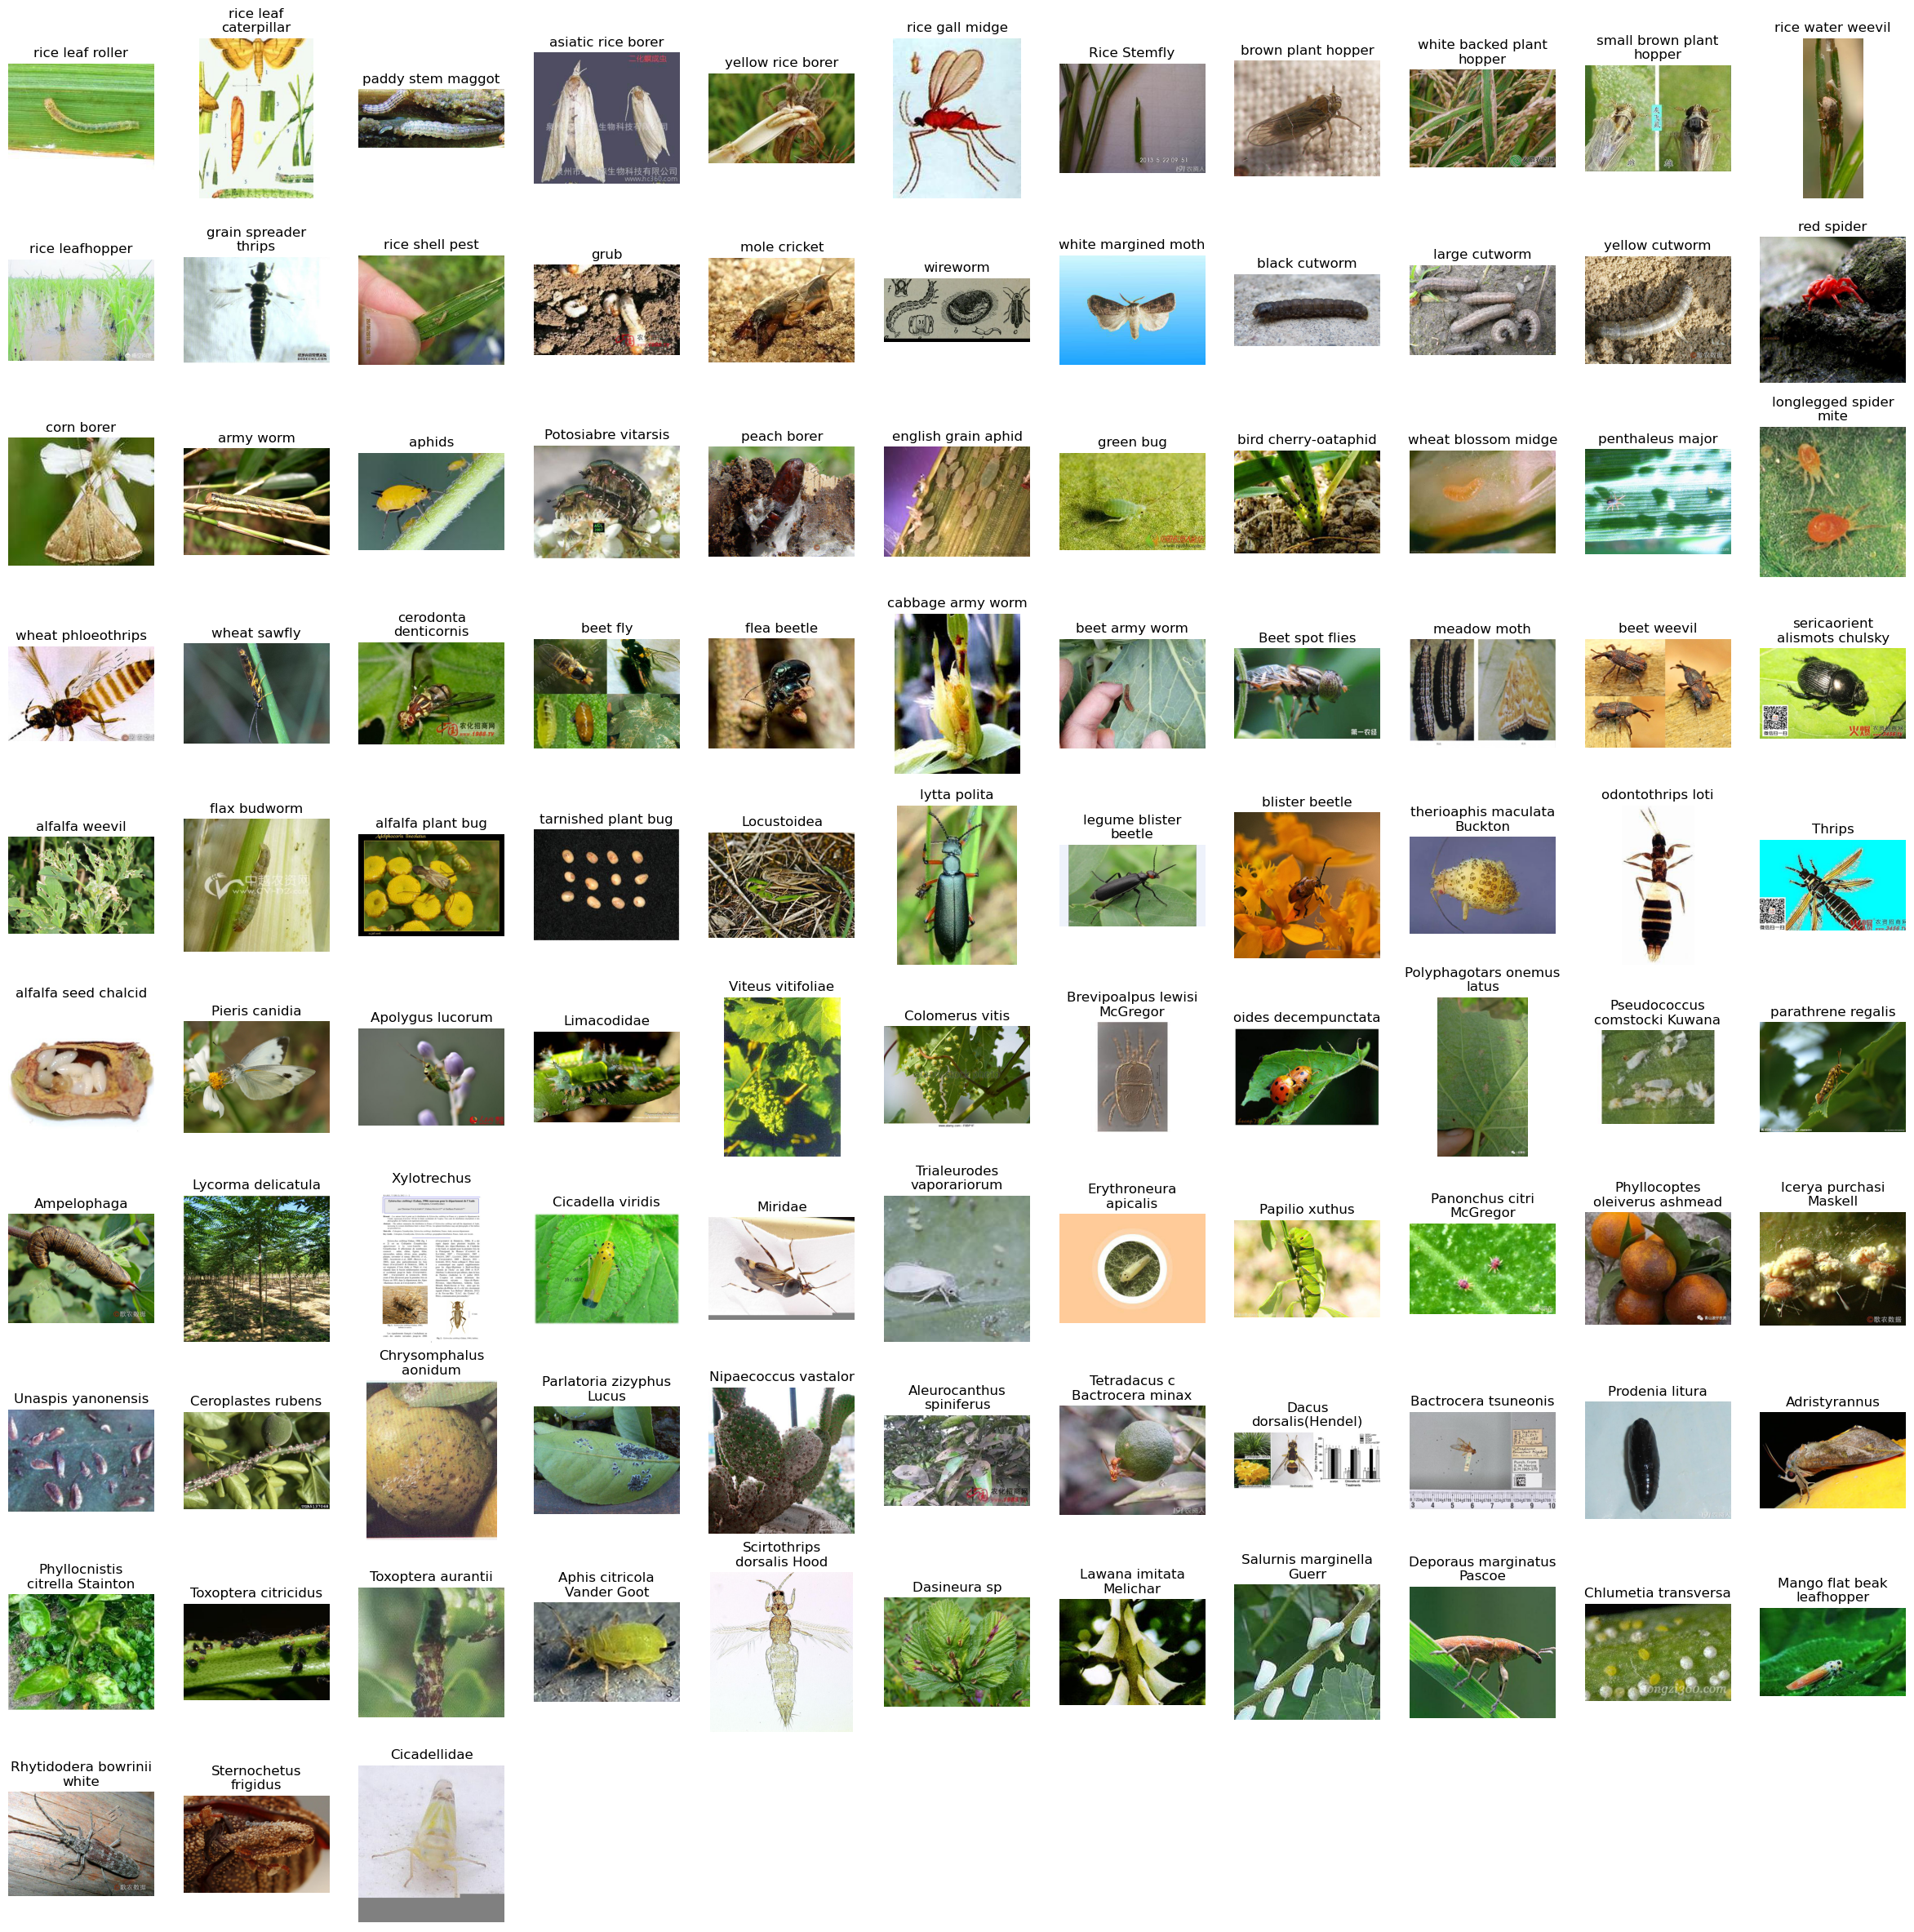

In [8]:
fig, axs = plt.subplots(10,11,figsize=(30,30))
images = []
for i in classes.label:
    random_img = random.choice(train_df[train_df.label==i-1].image_path.values)
    label = classes.name[i-1]
    img = plt.imread(os.path.join(TRAIN_DIR,str(i-1),random_img))
    images.append(img)

[ax.imshow(image) for image,ax in zip(images,axs.ravel())]
[ax.set_title("\n".join(wrap(label,20))) for label,ax in zip(list(classes.name),axs.ravel())]
[ax.set_axis_off() for ax in axs.ravel()]
plt.show()

# Proposed Solution


It is essential to establish a strong connection to the problem at hand. In this case, correctly identifying insects in farming scenarios is crucial for pest control, determining optimal cultivation practices, and minimizing crop damage. By accurately classifying insects, farmers can take targeted actions and make informed decisions to optimize crop yield and reduce economic losses. 
The correct classification of insects is crucial for effective farming of crops from an economic perspective. To achieve this, we will employ an image classifier, such as a convolutional neural network (CNN) which is a multiclass classifier and by creating our own (explained below). By utilizing multiway classifiers, we take an input image and accurately classify it into predefined classes within the dataset.

To construct a multiclass classifier, we will leverage different models like Linear Discriminant Analysis (LDA) and a neural network with a Multi-Layer Perceptron (MLP), aka CNN. The Sklearn library provides convenient methods for building these models and creating a classifier. It offers various options for the number of layers and solvers, allowing us to experiment and optimize the performance of the classifier. 

It's important to highlight the effectiveness of image classifiers in handling complex visual data. CNNs, in particular, excel at extracting features from images, enabling accurate classification, and combined with the use of LDA,  allows us to handle multiple classes and make predictions accordingly.

The data set that we are currently using contains a training, test, and validation set, allowing us to perform rigorous testing and evaluation. Cross-validation techniques, such as k-fold validation, will also be applied to assess the generalization capability of the models.

To establish a benchmark for testing our solution, we can utilize models that have shown high performance on similar tasks. One such model is AlexNet, which achieved impressive results on the ImageNet dataset, a large-scale image classification benchmark. By comparing the performance of our model against AlexNet, we can assess its effectiveness and determine areas for improvement.


# Evaluation Metrics

We will be using a confusion matrix as an evaluation metric for this project. Utilizing Precision and recall taken from the confusion matrix will allow us to create evaluation metrics. Additionally, we will use AlexNet, which is the benchmark model used for image classification.


The formulas included in this project:
\begin{align*}
Precision: \frac{TP}{TP + FP}\\
Recall: \frac{TP}{TP + FN}\\
Accuracy: \frac{TP + TN}{TP + TN + FP + FN}\\
F1: \frac{2*Precision * Recall}{Precision + Recall}
\end{align*}


# Preliminary results

NEW SECTION!

Please show any preliminary results you have managed to obtain.

Examples would include:
- Analyzing the suitability of a dataset or alogrithm for prediction/solving your problem 
- Performing feature selection or hand-designing features from the raw data. Describe the features available/created and/or show the code for selection/creation
- Showing the performance of a base model/hyper-parameter setting.  Solve the task with one "default" algorithm and characterize the performance level of that base model.
- Learning curves or validation curves for a particular model
- Tables/graphs showing the performance of different models/hyper-parameters

The dataset contains over 75k images and about 737 samples per a class. This is suitable to work with for solving a problem such as multi class classification, as there is a large amount of data for the model to generalize from. The problem with this dataset is that due to the large sum of data and the high dimensionality of the inputs, the model is hard to make computationally efficient and iterations take a long time to run. 
Our preliminary base model is a Resnet34 which is a convolutional neural network that utilizes residual blocks to take in an input image of 34x34 and output a classification. All input images are resized into a 34x34 image in order to feed this into the NN. The data is also transformed in a variety of psuedo random ways. The transforms that are applied to the input data are; a random vertical flip, a random adjustment to the sharpness, a random horizontal flip and color jitter. These flip transformations are used to increase the datasets size during training and also reduce overfitting and introduce diversity allowing the model to better generalize. 

We use Convolutional Neural Network (CNN) to classify multi-layer data. The dataset contains over 75k images and about 737 samples per a class. This is suitable to work with for solving a problem such as multi class classification, as there is a large amount of data for the model to generalize from. 

Here, we define two functions below for our image classification process: 

* *InsectModel* uses the vision transformer based size model to classify our insect images
* *InsectDataset* loading preprocessing image 

In [9]:
class InsectModel(nn.Module):
    def __init__(self,num_classes):
        super(InsectModel, self).__init__()
        self.num_classes = num_classes
        self.model = timm.create_model('vit_base_patch16_224',pretrained=True,num_classes=num_classes)
    def forward(self, image):
        return self.model(image)

In [10]:
def check_accuracy_part34(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            #f1_scores.append(f1_score(y.cpu().detach().numpy(),preds,average = 'micro'))
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        acc_list.append(acc)
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

We train model using epoch hyperparameter, which means that the algorithm will loop through the entire training dataset. We also use backward pass method to propagate the error while training.

In [11]:
iter_list = []
acc_list = []
loss_list = []
labels = np.arange(102)
f1_scores = []
from sklearn.metrics import f1_score
def train_part34(model, optimizer, epochs=1):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(train_loader):
        
            
            model.train()  
            x = x.to(device=device, dtype=dtype).float()  
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)
            #f1_scores = f1_score(y.cpu().detach().numpy(),host_scores,average = 'micro',labels = labels)
            # Zero out all the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            if t % print_every == 0:
                loss_list.append(loss.item())
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
                check_accuracy_part34(valid_loader, model)
                iter_list.append(t)
                print()
                


In [ ]:
channel_1 = 34
channel_2 = 68
model = InsectModel(102)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
#print(train_loader)
train_part34(model, optimizer, epochs=1)

In [ ]:
print(f1_scores)
fig,ax = plt.subplots(2)
ax[0].set_title('Accuracy and Loss vs Iteration')
ax[0].plot(iter_list,acc_list,label = 'Accuracy')
ax[1].plot(iter_list,loss_list,label = 'Loss',c = 'r')
ax[0].legend()
ax[1].legend()
#plt.ylabel("Accuracy")
plt.xlabel("Iteration")

acc_list = np.array(acc_list)
#print(acc_list[acc_list.argmax()])

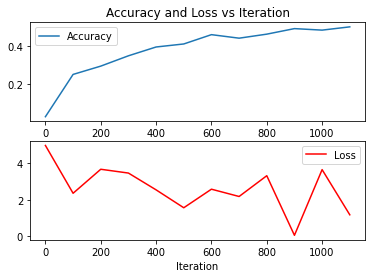

Based on our findings, we get over 55% accuracy on our testing and the results will be more accurate as we have more iterations. This shows that using CCN is an optimal solution for image classification. Moreover, we used ResNet34 a type of convolutional neural network for analyzing the sustainability of an algorithm for solving the problem. Because we have multiple layers of data from images, we have to ensure that every layers count in iterations.

In [ ]:
class ThreeLayerConvNet(nn.Module):
    def __init__(self, in_channel, channel_1, channel_2, num_classes):
        super().__init__()
      
        self.conv_1 = nn.Conv2d(in_channel, channel_1, (5,5), padding=2)
        nn.init.kaiming_normal_(self.conv_1.weight)
        self.conv_2 = nn.Conv2d(channel_1, channel_2, (3,3), padding=1)
        nn.init.kaiming_normal_(self.conv_2.weight)

        self.fc1 = nn.Linear(73984, 4)
        self.relu = nn.ReLU(inplace=True)
        


    def forward(self,x):
        scores = None
        x = self.relu(self.conv_2(self.relu((self.conv_1(x)))))
        x = flatten(x)
        scores = self.fc1(x)
        return scores

def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

We attemped to use a Three Layer Convolutional Network, but it performed poorly on the dataset. For now, we have decided to put this off to the side, giving ourselves the possibility to going back to it.

# Ethics & Privacy

The dataset used is readily available publicly on Kaggle. This eliminates the issues with data security and retention, as the data is already public. The data is sourced primarily from the Internet, relying on top 2000 search engine results for the names of insects, which could result in some collection bias. Video clips containing the insects are also used, which are captured as images at 5 frames per second. 
The images in the dataset are of insects, and do not involve human subjects or locations. This eliminates issues with consent, personally identifiable information, protected group status, or stereotype perpetuation. The output given by the algorithm may have harmful implications if insects are incorrectly identified as pests, as the overuse of pesticides can impact the environment. 

# Team Expectations 

Put things here that cement how you will interact/communicate as a team, how you will handle conflict and difficulty, how you will handle making decisions and setting goals/schedule, how much work you expect from each other, how you will handle deadlines, etc...
* *Team Expectation 1:* Acceptable response times and commitment to the project.
* *Team Expectation 2:* Quickly relay information if some deadlines can't be met.
* *Team Expecation 3:* Help eachother in areas where you can.
* *Team Expecation 4:* Be Quick and Honest about the ability to meet deadlines.

# Project Timeline Proposal

UPDATE THE PROPOSAL TIMELINE ACCORDING TO WHAT HAS ACTUALLY HAPPENED AND HOW IT HAS EFFECTED YOUR FUTURE PLANS

| Meeting Date  | Meeting Time| Completed Before Meeting  | Discuss at Meeting |
|---|---|---|---|
| 5/17  |  7:30 PM |  Brainstorm topics/questions (all)  | Determine best form of communication; Discuss and decide on final project topic; discuss hypothesis; background research | 
| 5/20  |  12 PM |  Do theoretical research on model performance improvement techniques (Tyden) | Discuss findings and analyze evaluation metrics | 
| 5/25  | 10 AM  | Finalize Dataset Search, Start Dataset Analysis (Areen)  | Assess group members' skills to lead each specific part   |
| 5/28  | 6 PM  |  Analyze Dataset; Begin programming for project (Tyden) | Discuss/edit project code; Complete project |
| 6/1  | 12 PM  | Complete analysis; Draft results/conclusion/discussion (All)| Discuss/edit full project |
| 6/9 | Before 11:59 PM  | NA | Turn in Final Project  |

# Footnotes
<a name="USDA"></a>1.[^](#USDA): United States Department of Agriculture (2 Dec 2022) What is agriculture's share of the overall U.S. economy. *United States Department of Agriculture*. https://www.ers.usda.gov/data-products/chart-gallery/gallery/chart-detail/?chartId=58270<br> 
<a name="Insect Classification"></a>2.[^](#InsectClass): Thenmozhi Kasinathan, Dakshayani Singaraju, Srinivasulu Reddy Uyyala,
Insect classification and detection in field crops using modern machine learning techniques,
Information Processing in Agriculture,
Volume 8, Issue 3,
2021,
Pages 446-457,
ISSN 2214-3173,
https://doi.org/10.1016/j.inpa.2020.09.006.
(https://www.sciencedirect.com/science/article/pii/S2214317320302067)<br> 
<a name="IP102"></a>3.[^](#IP102): Ratul Mahjabin (2022) IP102-Dataset https://www.kaggle.com/datasets/rtlmhjbn/ip02-dataset?select=test.txt<br>
<a name="National"></a>4.[^](#National): Xia D, Chen P, Wang B, Zhang J, Xie C. Insect Detection and Classification Based on an Improved Convolutional Neural Network. Sensors (Basel). 2018 Nov 27;18(12):4169. doi: 10.3390/s18124169. PMID: 30486481; PMCID: PMC6308804.<br>